# Tech Industry Salaries Data Analysis Report

Exploring Salary Trends in the tech industry

📅 Date: March 2025

✍️ Author: Natthapat Sakulborrirug

## 1. Introduction

## 2. Executive Summary

## 💾 The data

The data comes from a survey hosted by an HR consultancy, available in `'salaries.csv'`.

#### Each row represents a single employee's salary record for a given year:
- **`work_year`** - The year the salary was paid.  
- **`experience_level`** - Employee experience level:  
  - **`EN`**: Entry-level / Junior  
  - **`MI`**: Mid-level / Intermediate  
  - **`SE`**: Senior / Expert  
  - **`EX`**: Executive / Director  
- **`employment_type`** - Employment type:  
  - **`PT`**: Part-time  
  - **`FT`**: Full-time  
  - **`CT`**: Contract  
  - **`FL`**: Freelance  
- **`job_title`** - The job title during the year.  
- **`salary`** - Gross salary paid (in local currency).  
- **`salary_currency`** - Salary currency (ISO 4217 code).  
- **`salary_in_usd`** - Salary converted to USD using average yearly FX rate.  
- **`employee_residence`** - Employee's primary country of residence (ISO 3166 code).  
- **`remote_ratio`** - Percentage of remote work:  
  - **`0`**: No remote work (<20%)  
  - **`50`**: Hybrid (50%)  
  - **`100`**: Fully remote (>80%)  
- **`company_location`** - Employer's main office location (ISO 3166 code).  
- **`company_size`** - Company size:  
  - **`S`**: Small (<50 employees)  
  - **`M`**: Medium (50–250 employees)  
  - **`L`**: Large (>250 employees)  

## 3. Import Libraries and Load Data

In [239]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from thefuzz import process
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

salaries_df = pd.read_csv('salaries.csv')
salaries_df.info()
salaries_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57194 entries, 0 to 57193
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           57194 non-null  int64 
 1   experience_level    57194 non-null  object
 2   employment_type     57194 non-null  object
 3   job_title           57194 non-null  object
 4   salary              57194 non-null  int64 
 5   salary_currency     57194 non-null  object
 6   salary_in_usd       57194 non-null  int64 
 7   employee_residence  57194 non-null  object
 8   remote_ratio        57194 non-null  int64 
 9   company_location    57194 non-null  object
 10  company_size        57194 non-null  object
dtypes: int64(4), object(7)
memory usage: 4.8+ MB


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Developer,168276,USD,168276,US,0,US,M
1,2024,MI,FT,Developer,112184,USD,112184,US,0,US,M
2,2024,EN,FT,Developer,180000,USD,180000,US,0,US,M
3,2024,EN,FT,Developer,133500,USD,133500,US,0,US,M
4,2024,EN,FT,Developer,122000,USD,122000,US,0,US,M


In [6]:
salaries_df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,57194.000000,5.719400e+04,57194.000000,57194.000000
mean,2023.776305,1.641818e+05,159223.565829,22.211246
std,0.519883,2.060327e+05,72155.164297,41.424262
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.094000e+05,109300.000000,0.000000
50%,2024.000000,1.495520e+05,149040.000000,0.000000
75%,2024.000000,2.000000e+05,200000.000000,0.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


### 📌 Findings:  
- 57194 rows, 11 Columns
- Data Types correct and do not need fixing
- Intial assumption going forward that data is clean due to nature of project (In real world ideally should perform EDA on each column's distribution of values)
  

## 4. Analysis Results

### 4.1 How many records are in the dataset, and what is the range of years covered?

In [10]:
# Get and store total records using shape function
total_records = salaries_df.shape[0]

# Get statistics related to range of years
min_year = salaries_df.work_year.min()
max_year = salaries_df.work_year.max()
year_range = max_year - min_year

In [11]:
analysis_text = f"""
#### 📌 Findings:  
- There are **{total_records}** records in the dataset
- The range of years covered is **{year_range}** from **{min_year} - {max_year}**
"""
display(Markdown(analysis_text))


#### 📌 Findings:  
- There are **57194** records in the dataset
- The range of years covered is **4** from **2020 - 2024**


### 4.2 What is the average salary (in USD) for Data Scientists and Data Engineers? Which role earns more on average?

In [198]:
# Quick Method: Matching "Data Scientist" and "Data Engineers" to job titles with exact match
ds_de_filter = (salaries_df["job_title"] == "Data Scientist") | (salaries_df["job_title"] == "Data Engineer")

# Create df using filter narrowing to only DS and DE 
ds_de = salaries_df[ds_de_filter]

# Aggregate average salary in USD data 
ds_de_agg = ds_de.groupby("job_title").agg(
    mean_salary =("salary_in_usd", "mean"), 
    median_salary=("salary_in_usd","median"),
    record_count=("salary_in_usd","count")).reset_index()
ds_de_agg


,job_title,mean_salary,median_salary,record_count
0,Data Engineer,149315.004391,140000.0,7970
1,Data Scientist,159397.074181,154660.0,9706


In [227]:
de_ds_earns_more_mean = ds_de_agg.loc[ds_de_agg["mean_salary"].idxmax(), "job_title"]
de_ds_earns_more_median = ds_de_agg.loc[ds_de_agg["median_salary"].idxmax(), "job_title"]

display(Markdown(f"""
**{de_ds_earns_more_mean}** has a higher mean income of {(ds_de_agg.loc[ds_de_agg["mean_salary"].idxmax(), "mean_salary"]).round(0)} 

**{de_ds_earns_more_median}** has a higher median income of {(ds_de_agg.loc[ds_de_agg["mean_salary"].idxmax(), "median_salary"]).round(0)}
"""))



**Data Scientist** has a higher mean income of 159397.0

**Data Scientist** has a higher median income of 154660.0


Quick Method very literal and does not account for roles named slightly differently that are technically still Data Scientists or Data Engineers


In [267]:
# Sample dataset
salaries = pd.DataFrame(salaries_df.job_title.unique())
salaries
# Define job categories
categories = ["Data Scientist", "Data Engineer","Data Analyst"]

def fuzzy_classify(title):
    match = process.extractOne(title, categories)
    
    # Handle cases where no match is found
    if match is None:
        return "Other"
    
    matched_title, score = match  # Extract match and similarity score
    return matched_title if score > 80 else "Other"

# Apply function safely
salaries["job_category_fuzzy"] = salaries[0].apply(fuzzy_classify)

salaries.to_csv('outback.csv', index=False)  



In [251]:
salaries

,0
0,Developer
1,Research Scientist
2,Software Engineer
3,Solution Architect
4,Manager
...,...
248,Principal Data Architect
249,Data Analytics Engineer
250,Cloud Data Architect
251,Lead Data Engineer


### 4.3 How many full-time employees based in the US work 100% remotely?

In [14]:
# Define conditions for 1) FT Employees, 2) Based in US, 3) Work 100% Remotely
conditions = (salaries_df.employment_type == 'FT') & (salaries_df.employee_residence == 'US') & (salaries_df.remote_ratio == 100)

# Sum total employees that meet condition
employees_ft_us_remote = conditions.sum()

display(Markdown(f"""
**{employees_ft_us_remote}** is the total number of **Full-Time, US-Based, Remote employees** in the dataset.  

However, the dataset records **each employee per year**, so we need to analyze it **by year** instead.  
Otherwise, a single employee who appears in multiple years would be **overcounted**.
"""))


**11125** is the total number of **Full-Time, US-Based, Remote employees** in the dataset.  

However, the dataset records **each employee per year**, so we need to analyze it **by year** instead.  
Otherwise, a single employee who appears in multiple years would be **overcounted**.


In [15]:
# Add boolean column to salaries_df to see which rows meet conditions
salaries_df["ft_us_remote"] = conditions

# Creates new df showing employees that meet conditions in each year
yearly_ft_us_remote = salaries_df.groupby("work_year").agg(
    total_ft_us_remote =("ft_us_remote", "sum"), 
    employees_surveyed=("ft_us_remote","count"),).reset_index()

yearly_ft_us_remote["pct_remote"] = yearly_ft_us_remote.total_ft_us_remote / yearly_ft_us_remote.employees_surveyed
# Markdown for reporting later
md = "```\n" + yearly_ft_us_remote.to_markdown(index=False) + "\n```"

yearly_ft_us_remote

,work_year,total_ft_us_remote,employees_surveyed,pct_remote
0,2020,20,75,0.266667
1,2021,59,218,0.270642
2,2022,710,1659,0.427969
3,2023,2296,8522,0.269420
4,2024,8040,46720,0.172089


In [16]:
# Get total_ft_us_remote value for the latest year 
latest_year_ft_us_remote = yearly_ft_us_remote[yearly_ft_us_remote["work_year"] == max_year].iloc[0]["total_ft_us_remote"]


#### 📌 Findings:  
- In 2024 (most recent year in dataset) there were **8040.0** full-time employees  based in the US working 100% remotely
- While Full Time US-Based Remote employees have risen, they have fallen in terms of proportion to number of overall surveyed employees


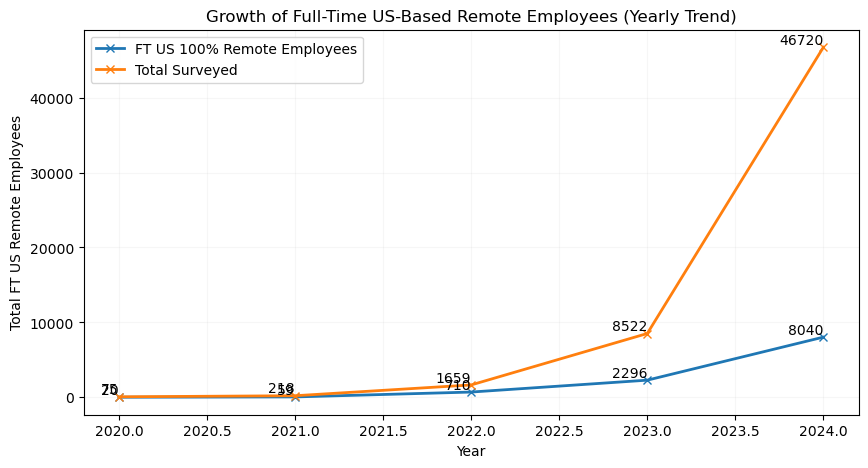


```
|   work_year |   total_ft_us_remote |   employees_surveyed |   pct_remote |
|------------:|---------------------:|---------------------:|-------------:|
|        2020 |                   20 |                   75 |     0.266667 |
|        2021 |                   59 |                  218 |     0.270642 |
|        2022 |                  710 |                 1659 |     0.427969 |
|        2023 |                 2296 |                 8522 |     0.26942  |
|        2024 |                 8040 |                46720 |     0.172089 |
```


In [17]:
display(Markdown(f"""
#### 📌 Findings:  
- In {max_year} (most recent year in dataset) there were **{latest_year_ft_us_remote}** full-time employees  based in the US working 100% remotely
- While Full Time US-Based Remote employees have risen, they have fallen in terms of proportion to number of overall surveyed employees
"""
                ))
plt.figure(figsize=(10, 5))
plt.plot(
    yearly_ft_us_remote.work_year, 
    yearly_ft_us_remote.total_ft_us_remote, 
    marker='x', linestyle='-', linewidth=2, label="FT US 100% Remote Employees"
)
plt.plot(
    yearly_ft_us_remote.work_year, 
    yearly_ft_us_remote.employees_surveyed, 
    marker='x', linestyle='-', linewidth=2, label="Total Surveyed"
)

# Labels and Title
plt.xlabel("Year")
plt.ylabel("Total FT US Remote Employees")
plt.title("Growth of Full-Time US-Based Remote Employees (Yearly Trend)")

# Show Data Points on the Graph
for i, value in enumerate(yearly_ft_us_remote.total_ft_us_remote):
    plt.text(yearly_ft_us_remote.work_year.iloc[i], value, f"{value}", ha="right", va="bottom")
for i, value in enumerate(yearly_ft_us_remote.employees_surveyed):
    plt.text(yearly_ft_us_remote.work_year.iloc[i], value, f"{value}", ha="right", va="bottom")

# Grid and Legend
plt.grid(True, linestyle='-', alpha=0.1)
plt.legend()

# Show the plot
plt.show()

display(Markdown(f"""
{md}
"""))

In [18]:
# Create a bar chart displaying the top 5 job titles with the highest average salary (in USD). - S
# Compare the average salaries for employees working remotely 100%, 50%, and 0%. What patterns or trends do you observe? - S
# Visualise the salary distribution (in USD) across company sizes (S, M, L). Which company size offers the highest average salary? - S

In [99]:
salaries_df
df = salaries_df.groupby("job_title").agg(
    count_jobs=("ft_us_remote", "count"),
    avg=('salary_in_usd',"mean")

).reset_index()
df.sort_values(by=['avg'], ascending=False).head(5)

,job_title,count_jobs,avg
23,Analytics Engineering Manager,1,399880.000000
126,Data Science Tech Lead,1,375000.000000
25,Applied AI ML Lead,2,292500.000000
162,Head of Machine Learning,9,288701.000000
152,Engineering Manager,268,262525.615672


In [103]:
salaries_df
df = salaries_df.groupby("job_title").agg(
    count_jobs=("ft_us_remote", "count"),
    avg=('salary_in_usd',"median")

).reset_index()
df.sort_values(by=['avg'], ascending=False).head(5)

,job_title,count_jobs,avg
23,Analytics Engineering Manager,1,399880.0
126,Data Science Tech Lead,1,375000.0
162,Head of Machine Learning,9,300000.0
25,Applied AI ML Lead,2,292500.0
181,Machine Learning Performance Engineer,2,262500.0


In [111]:
salaries_df
df = salaries_df.groupby("remote_ratio").agg(
    count_jobs=("ft_us_remote", "count"),
    avg=('salary_in_usd',"mean"),

).reset_index()
df.sort_values(by=['avg'], ascending=False).head(5)

,remote_ratio,count_jobs,avg
0,0,44355,162401.766836
2,100,12568,149675.074395
1,50,271,81866.867159


In [ ]:
# Visualise the salary distribution (in USD) across company sizes (S, M, L). Which company size offers the highest average salary? - S
salaries_df
df = salaries_df.groupby("remote_ratio").agg(
    count_jobs=("ft_us_remote", "count"),
    avg=('salary_in_usd',"mean"),

).reset_index()
df.sort_values(by=['avg'], ascending=False).head(5)

In [19]:
# Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, 
# Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?

# Develop a predictive model to estimate an employee’s salary (in USD) using experience level, 
# company location, and remote ratio. Which features are the strongest predictors of salary?

# Expand your model by incorporating additional features, such as company size and employment type. 
# Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions even more accurate future salary predictions even more accurate.